In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import datetime as dt
import warnings 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../input/uber-database/UBER.csv")
train_data=df[:485]
test_data=df[485:]
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
1,2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2,2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
3,2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
4,2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500
...,...,...,...,...,...,...,...
600,2021-09-27,46.770000,47.430000,46.189999,47.250000,47.250000,23034800
601,2021-09-28,46.700001,47.000000,45.759998,45.980000,45.980000,23707900
602,2021-09-29,46.000000,46.529999,44.299999,44.520000,44.520000,24599500
603,2021-09-30,44.709999,45.365002,43.860001,44.799999,44.799999,16650600


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       605 non-null    object 
 1   Open       605 non-null    float64
 2   High       605 non-null    float64
 3   Low        605 non-null    float64
 4   Close      605 non-null    float64
 5   Adj Close  605 non-null    float64
 6   Volume     605 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 33.2+ KB


In [4]:
scaler=StandardScaler()
scaled_data=scaler.fit(np.array(train_data["Close"]).reshape(-1, 1)).transform(np.array(train_data["Close"]).reshape(-1, 1))

In [5]:
# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [7]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)

model.fit(x_train, y_train,  epochs=25, batch_size = 32, callbacks = [checkpointer])


2022-09-19 09:39:23.514799: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

2022-09-19 09:39:24.425491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


14/14 [==============================] - 8s 137ms/step - loss: 0.5109
Epoch 2/25
14/14 [==============================] - 2s 132ms/step - loss: 0.1955
Epoch 3/25
14/14 [==============================] - 2s 129ms/step - loss: 0.1472
Epoch 4/25
14/14 [==============================] - 2s 134ms/step - loss: 0.1213
Epoch 5/25
14/14 [==============================] - 2s 130ms/step - loss: 0.1140
Epoch 6/25
14/14 [==============================] - 2s 129ms/step - loss: 0.1168
Epoch 7/25
14/14 [==============================] - 2s 172ms/step - loss: 0.1057
Epoch 8/25
14/14 [==============================] - 2s 129ms/step - loss: 0.0974
Epoch 9/25
14/14 [==============================] - 2s 129ms/step - loss: 0.0867
Epoch 10/25
14/14 [==============================] - 2s 133ms/step - loss: 0.0961
Epoch 11/25
14/14 [==============================] - 2s 129ms/step - loss: 0.0930
Epoch 12/25
14/14 [==============================] - 2s 130ms/step - loss: 0.0892
Epoch 13/25
14/14 [=================

In [8]:
actual_prices = test_data['Close'].values
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)

In [9]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [10]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

In [11]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

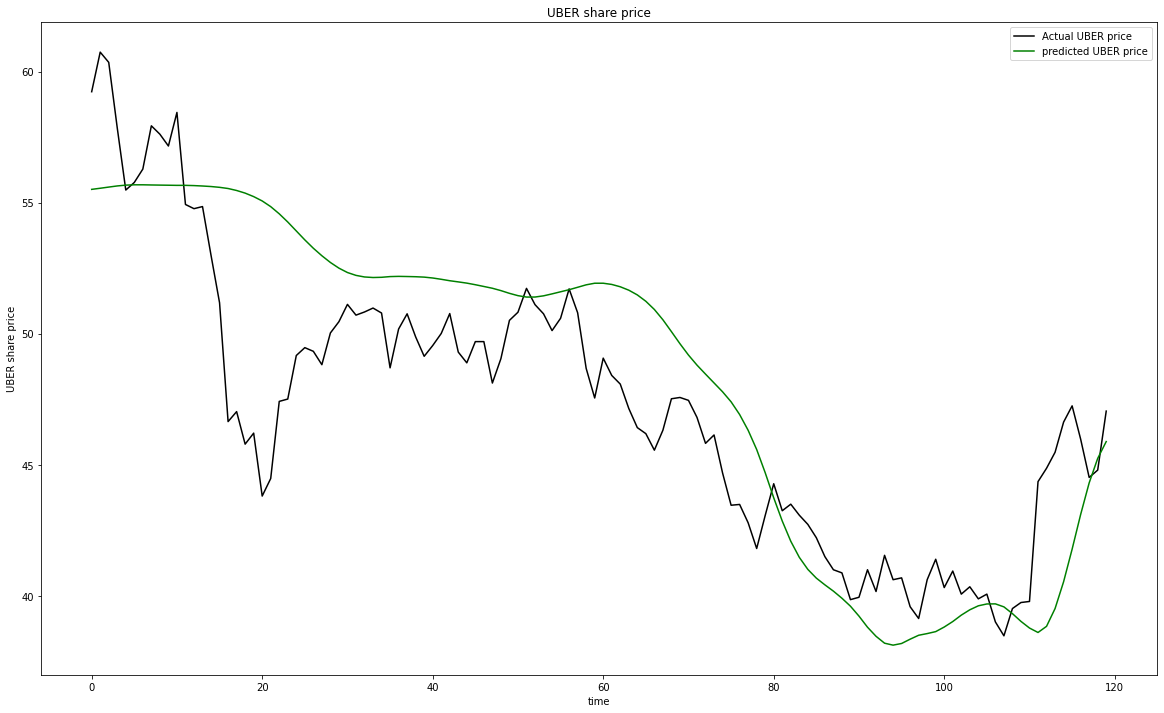

In [12]:
plt.rcParams["figure.figsize"] = (20, 12)
plt.plot(actual_prices, color='black', label=f"Actual UBER price")
plt.plot(predicted_prices, color= 'green', label=f"predicted UBER price")
plt.title(f"UBER share price")
plt.xlabel("time")
plt.ylabel(f"UBER share price")
plt.legend()
plt.show()